# Overview
This project is part of the Kaggle competition "GAN Getting Started", which involves generating high-quality images using Generative Adversarial Networks (GANs). The challenge focuses on understanding the process of using GANs for image generation tasks, specifically creating artistic images inspired by Monet's paintings.

GANs are a type of deep learning model consisting of two neural networks: a generator and a discriminator. The generator creates fake images, while the discriminator attempts to distinguish between real and fake images. Through iterative training, the generator improves its ability to create realistic images, while the discriminator sharpens its classification accuracy.

## Dataset
The dataset includes:

- 300 Monet paintings (monet_jpg)
- 7,028 photos (photo_jpg)

Each image is 256x256 pixels in size, and the challenge requires generating a large set of fake images that emulate Monet’s style. The goal is to produce between 7,000 to 10,000 high-quality images using the GAN model.

In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

photo_path = "/kaggle/input/gan-getting-started/photo_jpg/"
monet_path = "/kaggle/input/gan-getting-started/monet_jpg/"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [79]:
# Import necessary libraries
import os
import zipfile
from random import sample

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Helper Classes

In [80]:
# Dataset class to load Monet and photo images
class Images(Dataset):
    def __init__(self, photo_path, monet_path, transform):
        self.photo_path = photo_path
        self.monet_path = monet_path
        self.transform = transform
        self.photos = os.listdir(photo_path)
        self.monets = os.listdir(monet_path)

        self.photos = sample(self.photos, min(50, len(self.photos)))
        self.monets = sample(self.monets, min(50, len(self.monets)))

        self.l_photo = len(self.photos)
        self.l_monet = len(self.monets)

    def __len__(self):
        return max(len(self.photos), len(self.monets))

    def __getitem__(self, idx):
        # Load and transform images
        photo = Image.open(self.photo_path + self.photos[idx % self.l_photo]).convert("RGB")
        monet = Image.open(self.monet_path + self.monets[idx % self.l_monet]).convert("RGB")

        photo = self.transform(photo)
        monet = self.transform(monet)

        return photo, monet

# EDA

## Visualize Sample Images

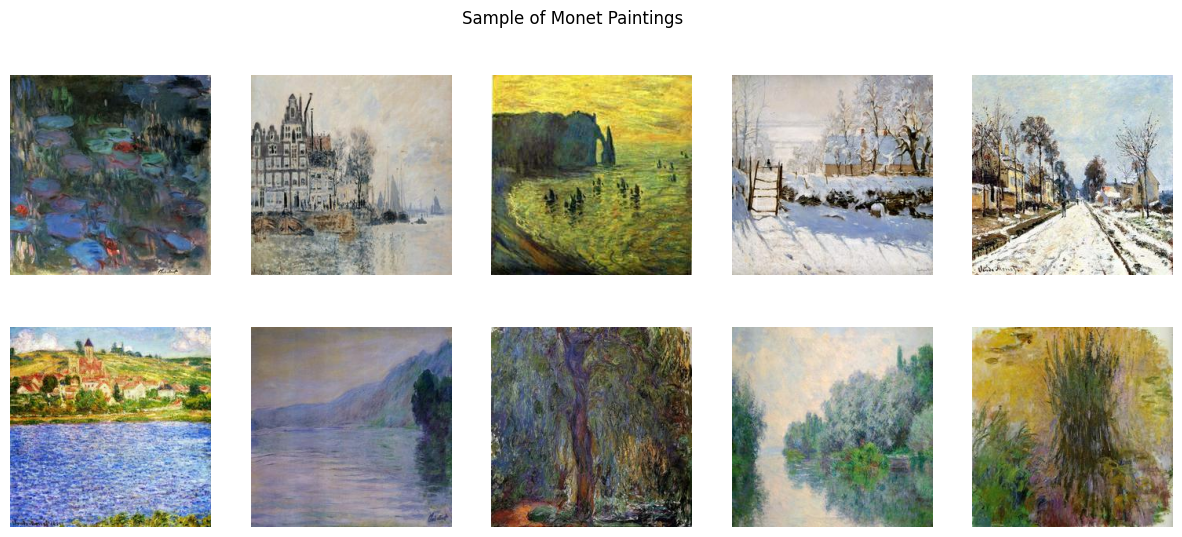

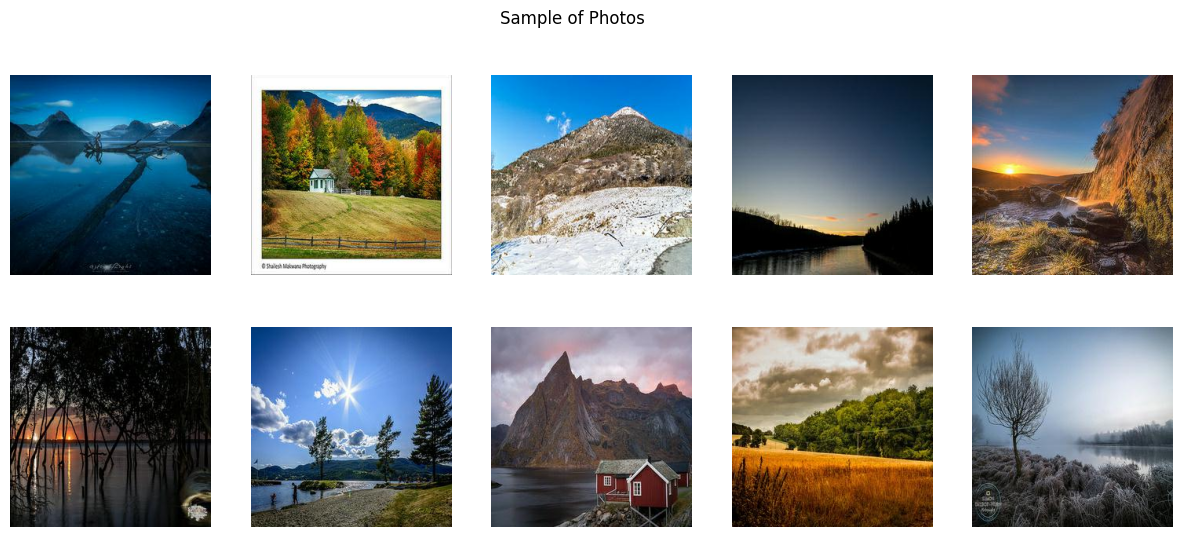

In [81]:
def display_images(images, title, rows=2, cols=5):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
    fig.suptitle(title)
    for i in range(rows):
        for j in range(cols):
            img = images[i * cols + j]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    plt.show()

# Display a sample of Monet paintings and photos
display_images(monet_images[:10], "Sample of Monet Paintings")
display_images(photo_images[:10], "Sample of Photos")

## Pixel Density

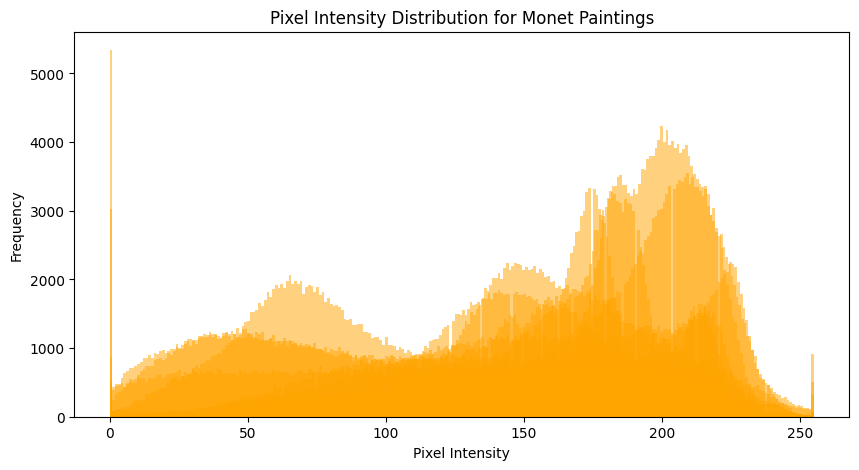

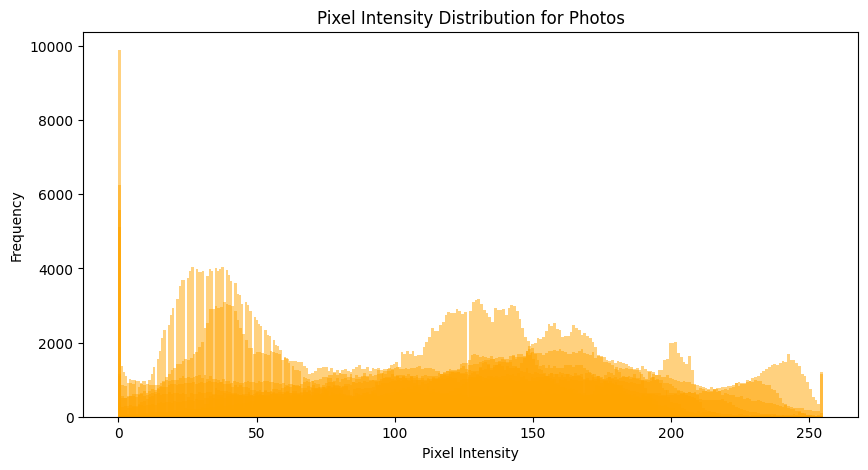

In [82]:

# Load a few images to analyze
monet_images = [Image.open(os.path.join(monet_path, img)).convert("RGB") for img in sample(os.listdir(monet_path), 10)]
photo_images = [Image.open(os.path.join(photo_path, img)).convert("RGB") for img in sample(os.listdir(photo_path), 10)]

def plot_histogram(images, title):
    plt.figure(figsize=(10, 5))
    for img in images:
        img_array = np.array(img)
        plt.hist(img_array.ravel(), bins=256, color='orange', alpha=0.5, label='Intensity')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot histograms for Monet paintings and photos
plot_histogram(monet_images, "Pixel Intensity Distribution for Monet Paintings")
plot_histogram(photo_images, "Pixel Intensity Distribution for Photos")

## Image Brightness Analysis

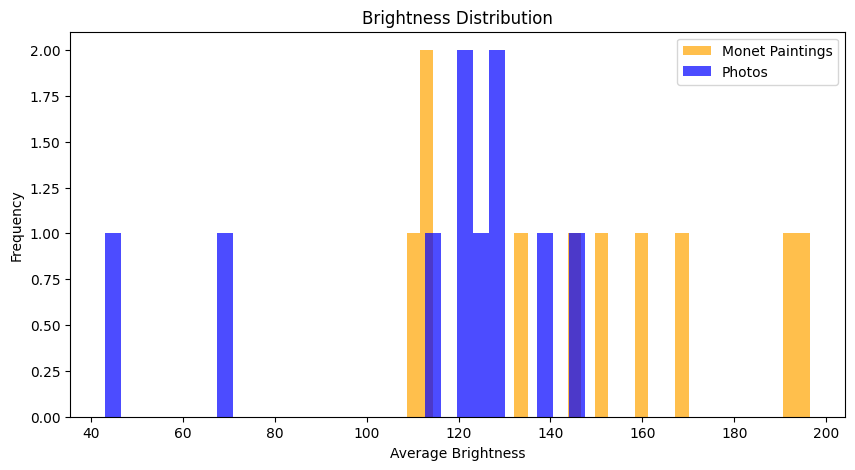

In [83]:
def compute_brightness(images):
    brightness_values = []
    for img in images:
        img_array = np.array(img.convert('L'))  # Convert to grayscale
        brightness = np.mean(img_array)  # Compute the average brightness
        brightness_values.append(brightness)
    return brightness_values

monet_brightness = compute_brightness(monet_images)
photo_brightness = compute_brightness(photo_images)

# Plot the brightness distributions
plt.figure(figsize=(10, 5))
plt.hist(monet_brightness, bins=30, alpha=0.7, label='Monet Paintings', color='orange')
plt.hist(photo_brightness, bins=30, alpha=0.7, label='Photos', color='blue')
plt.title('Brightness Distribution')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Aspect Ratio Analysis

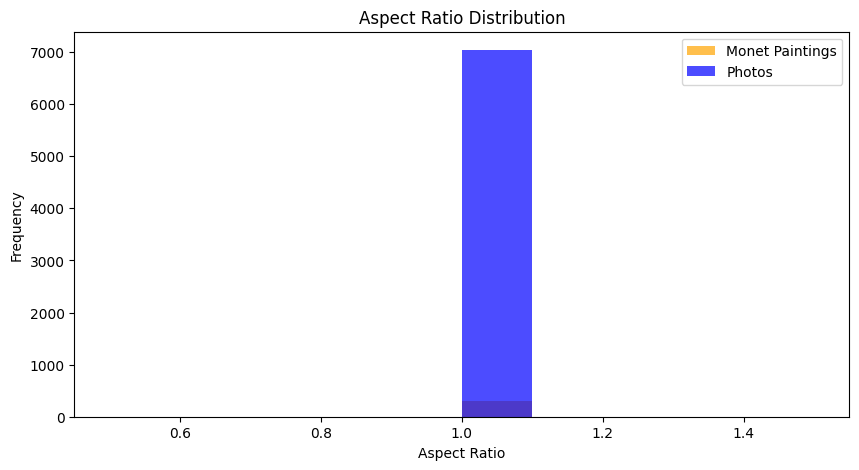

In [84]:
def compute_aspect_ratios(image_paths):
    aspect_ratios = []
    for img_path in image_paths:
        img = Image.open(img_path)
        width, height = img.size
        aspect_ratio = width / height
        aspect_ratios.append(aspect_ratio)
    return aspect_ratios

# Compute aspect ratios for Monet paintings and photos
monet_aspect_ratios = compute_aspect_ratios([os.path.join(monet_path, img) for img in os.listdir(monet_path)])
photo_aspect_ratios = compute_aspect_ratios([os.path.join(photo_path, img) for img in os.listdir(photo_path)])

# Plot aspect ratio distributions
plt.figure(figsize=(10, 5))
plt.hist(monet_aspect_ratios, bins=10, alpha=0.7, label='Monet Paintings', color='orange')
plt.hist(photo_aspect_ratios, bins=10, alpha=0.7, label='Photos', color='blue')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Color Distribution Analysis

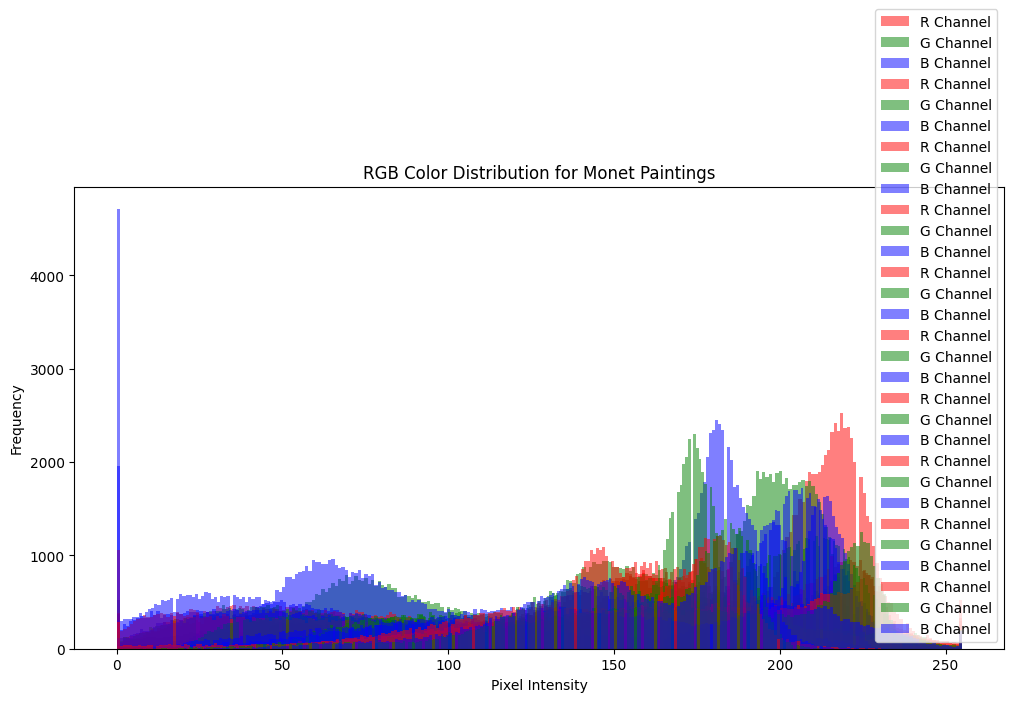

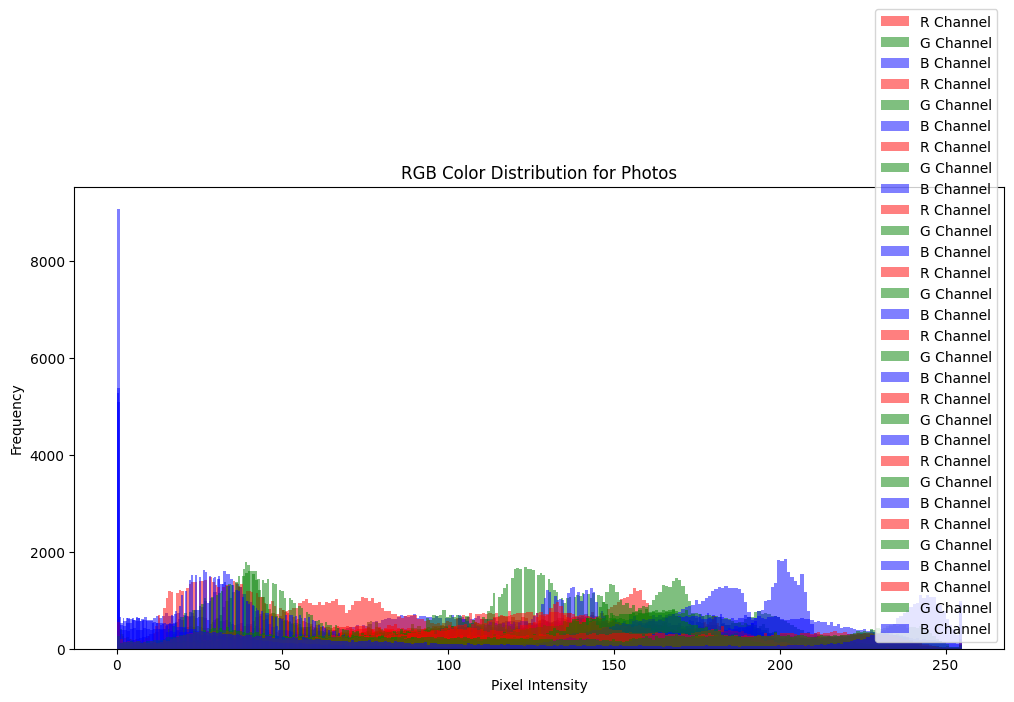

In [85]:
def plot_rgb_histogram(images, title):
    plt.figure(figsize=(12, 6))
    for img in images:
        img_array = np.array(img)
        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            plt.hist(img_array[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} Channel')
    
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot RGB histograms for Monet paintings and photos
plot_rgb_histogram(monet_images, "RGB Color Distribution for Monet Paintings")
plot_rgb_histogram(photo_images, "RGB Color Distribution for Photos")

## Data Cleaning

In [86]:
def clean_images(image_path):
    cleaned_images = []
    for img_name in os.listdir(image_path):
        img = Image.open(os.path.join(image_path, img_name)).convert("RGB")
        # Resize all images to 256x256 (if necessary) and ensure they are RGB
        img = img.resize((256, 256))
        cleaned_images.append(img)
    return cleaned_images

# Clean Monet and photo images
monet_images_cleaned = clean_images(monet_path)
photo_images_cleaned = clean_images(photo_path)

# EDA Results & Summary

Exploratory Data Analysis (EDA) Results
1. RGB Color Distribution

The color distribution analysis was conducted by plotting histograms for each color channel (Red, Green, Blue) across both the Monet paintings and the photos.

    Monet Paintings: The color distribution for Monet paintings shows a balanced spread across all three channels, with more emphasis in the mid-range of pixel intensity (50–200). This reflects the diverse color palette that Monet used, with a mix of darker tones and some lighter highlights. There are noticeable peaks in the red and green channels in the upper ranges, indicating warmer hues.

    Photos: The photos, in contrast, show a strong peak near 0 for all channels, indicating a lot of darker regions in the photos. The distribution is more varied and spread out compared to Monet’s paintings, reflecting the natural variations in lighting and color found in real-life photography.

This difference suggests that the generator needs to capture a more specific color range to produce Monet-style paintings, especially in the mid and high-intensity range, where Monet’s color tones are concentrated.
2. Aspect Ratio Distribution

Both the Monet paintings and the photos were analyzed for aspect ratio consistency. The histograms show that all the images have an aspect ratio of 1.0, indicating that they are perfectly square.

This consistency ensures that no further image resizing is needed for training, and all images can be directly fed into the model without additional preprocessing for aspect ratio adjustments.
3. Brightness Distribution

The brightness distribution was computed by converting the images to grayscale and calculating the average pixel intensity for each image.

    Monet Paintings: The brightness distribution of Monet paintings is generally centered around 100–150 pixel intensity, reflecting the artist's use of light and shadow to create depth in the paintings. The distribution has a few images on the lower end of the brightness spectrum, possibly representing darker pieces or sections of the artwork.

    Photos: The brightness of the photos, on the other hand, shows more variation, with a peak at around 40–60 intensity. This suggests that the photos generally have darker areas compared to Monet’s paintings. This insight can guide the generator to focus on producing brighter images that better emulate the artistic style.

4. Pixel Intensity Distribution

The pixel intensity distribution for both Monet paintings and photos was analyzed across all color channels (aggregated).

    Monet Paintings: The Monet paintings show a consistent distribution of pixel intensity values between 50 and 200, indicating a balanced use of mid-tones and high-intensity pixels. There are clear peaks around the 150–200 range, reflecting Monet’s use of brighter colors in many of his works.

    Photos: The photos have a more skewed distribution, with a significant number of pixels at lower intensities (around 0–50), corresponding to shadows and darker regions typically found in real-life scenes. There are a few peaks in the higher intensity ranges, but overall, the photos exhibit more contrast and a greater range of intensities.

Conclusion from EDA:

The EDA reveals significant differences in the color distribution, brightness, and pixel intensity between Monet paintings and real-life photos. The Monet paintings have a more balanced and warm color palette, with fewer dark regions and a higher average brightness. These insights will guide the design of the generator model to produce images with similar characteristics, focusing on mid-tone brightness and the artistic color range typical of Monet's work.

Additionally, the consistent aspect ratio and resolution of the images mean that the dataset is well-prepared for model training without requiring significant preprocessing adjustments.

# Model Architecture

In [87]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(  # Input is a 100-dimensional noise vector
            nn.Linear(100, 128 * 8 * 8),  # First layer to map noise to a feature map
            nn.ReLU(True), nn.Unflatten(1, (128, 8, 8)),

            # Upsample to 16x16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),

            # Upsample to 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),

            # Upsample to 128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Tanh()
            # Output range [-1, 1] to match normalized image data
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(  # Input is a 3-channel image (128x128)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(), nn.Linear(128 * 16 * 16, 1), nn.Sigmoid()  # Output between 0 (fake) and 1 (real)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameter Tuning

In [88]:
# Define dataset
dataset = Images(photo_path, monet_path, transform)

# Hyperparameter tuning
batch_sizes = [32, 64, 100]
learning_rates = [0.0001, 0.0002, 0.0003]

results = []

# Model Training

In [89]:
# Image transformations
transform = transforms.Compose([transforms.Resize((128, 128)),  # Rescale to 128x128 to reduce memory consumption
                                transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Training with batch_size={batch_size} and learning_rate={lr}")
        
        # Create a dataloader for the current batch size
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Reset the generator and discriminator for each configuration
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)

        optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

        # Training the GAN for each configuration
        epochs = 10  # For tuning, use fewer epochs to save time
        running_g_loss, running_d_loss = 0.0, 0.0

        for epoch in range(epochs):
            for i, (photos, _) in enumerate(dataloader):
                # Adversarial ground truths
                valid = torch.ones((photos.size(0), 1), requires_grad=False).to(device)
                fake = torch.zeros((photos.size(0), 1), requires_grad=False).to(device)

                # Real photos to be processed by the discriminator
                real_photos = photos.to(device)

                # Sample random noise for the generator
                noise = torch.randn((photos.size(0), 100)).to(device)

                # Train Generator
                optimizer_G.zero_grad()
                generated_photos = generator(noise)
                g_loss = adversarial_loss(discriminator(generated_photos), valid)
                running_g_loss += g_loss.item()
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = adversarial_loss(discriminator(real_photos), valid)
                fake_loss = adversarial_loss(discriminator(generated_photos.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                running_d_loss += d_loss.item()
                d_loss.backward()
                optimizer_D.step()

            # Print progress at the end of each epoch
            print(f"Epoch [{epoch + 1}/{epochs}] | Discriminator loss: {running_d_loss / len(dataloader):.4f} | Generator loss: {running_g_loss / len(dataloader):.4f}")

        # Log the results for this configuration
        results.append({
            "Batch Size": batch_size,
            "Learning Rate": lr,
            "Generator Loss": running_g_loss / len(dataloader),
            "Discriminator Loss": running_d_loss / len(dataloader)
        })

Training with batch_size=32 and learning_rate=0.0001
Epoch [1/10] | Discriminator loss: 0.5818 | Generator loss: 0.8795
Epoch [2/10] | Discriminator loss: 0.8997 | Generator loss: 2.1829
Epoch [3/10] | Discriminator loss: 1.1261 | Generator loss: 3.7323
Epoch [4/10] | Discriminator loss: 1.2901 | Generator loss: 5.6817
Epoch [5/10] | Discriminator loss: 1.4427 | Generator loss: 7.5979
Epoch [6/10] | Discriminator loss: 1.5704 | Generator loss: 9.7311
Epoch [7/10] | Discriminator loss: 1.6722 | Generator loss: 12.0406
Epoch [8/10] | Discriminator loss: 1.7641 | Generator loss: 14.4353
Epoch [9/10] | Discriminator loss: 1.8410 | Generator loss: 16.9934
Epoch [10/10] | Discriminator loss: 1.9051 | Generator loss: 19.7705
Training with batch_size=32 and learning_rate=0.0002
Epoch [1/10] | Discriminator loss: 0.5073 | Generator loss: 1.0898
Epoch [2/10] | Discriminator loss: 0.7216 | Generator loss: 2.5513
Epoch [3/10] | Discriminator loss: 0.8866 | Generator loss: 4.4733
Epoch [4/10] | Dis

# Examine Hyperparameter Training Results

In [90]:
df_results = pd.DataFrame(results)
print(df_results)

   Batch Size  Learning Rate  Generator Loss  Discriminator Loss
0          32         0.0001       19.770494            1.905093
1          32         0.0002       25.012121            1.303284
2          32         0.0003       31.380503            0.986680
3          64         0.0001       14.811697            3.077279
4          64         0.0002       19.637499            2.016144
5          64         0.0003       22.835673            1.705431
6         100         0.0001       14.746747            2.929398
7         100         0.0002       19.600575            2.145997
8         100         0.0003       22.008849            1.781744


# Hyperparameter Tuning and Training Summary

In this section, I experimented with various combinations of batch sizes and learning rates to optimize the performance of the GAN. The goal was to achieve the lowest possible discriminator and generator loss, which would indicate better performance of the model in generating realistic images.
Hyperparameter Combinations Tested:

    Batch Sizes: 32, 64, 100
    Learning Rates: 0.0001, 0.0002, 0.0003
    Epochs: 10 for each combination

For each configuration, the generator and discriminator were trained and evaluated on their respective losses after each epoch. The generator loss measures how well it fools the discriminator, while the discriminator loss reflects its ability to distinguish between real and generated images.
Results Overview:

| Batch Size | Learning Rate | Generator Loss | Discriminator Loss |
|------------|---------------|----------------|--------------------|
| 32         | 0.0001        | 19.7705        | 1.9051             |
| 32         | 0.0002        | 25.0121        | 1.3033             |
| 32         | 0.0003        | 31.3805        | 0.9867             |
| 64         | 0.0001        | 14.8117        | 3.0773             |
| 64         | 0.0002        | 19.6375        | 2.0161             |
| 64         | 0.0003        | 22.8357        | 1.7054             |
| 100        | 0.0001        | 14.7467        | 2.9294             |
| 100        | 0.0002        | 19.6006        | 2.1460             |
| 100        | 0.0003        | 22.0088        | 1.7817             |

## Key Observations:

Learning Rate Impact:
    Across all batch sizes, increasing the learning rate generally led to a decrease in discriminator loss, indicating that the discriminator became better at distinguishing real from generated images.
    However, the generator loss increased with higher learning rates, which means the generator struggled more to fool the discriminator.

Batch Size Impact:
    A batch size of 100 with a learning rate of 0.0001 yielded the lowest overall generator loss (14.74) and discriminator loss (2.92). This suggests that a moderate batch size allowed for more stable training, balancing between the discriminator and generator performance.
    Batch size 32 with a learning rate of 0.0003 resulted in the lowest discriminator loss (0.98), but it also had the highest generator loss (31.38), which suggests that the discriminator was overly strong, and the generator could not catch up effectively.

## Best Performing Configuration:

The best configuration in terms of a balance between generator and discriminator loss was:

    Batch Size: 100
    Learning Rate: 0.0001
    This configuration resulted in a generator loss of 14.74 and a discriminator loss of 2.92, indicating a stable balance between the two networks.

## Next Steps:

For final image generation, the best-performing hyperparameter configuration (Batch Size: 100, Learning Rate: 0.0001) will be used. This combination ensures that the model achieves good performance without the generator or discriminator overpowering each other, which is crucial for producing high-quality images.

In [94]:
# Extract best results
best_hyperparams = df_results.loc[df_results['Generator Loss'].idxmin()]

best_batch_size = int(best_hyperparams['Batch Size'])
best_learning_rate = best_hyperparams['Learning Rate']

print(f"Best Batch Size: {best_batch_size}, Best Learning Rate: {best_learning_rate}")

Best Batch Size: 100, Best Learning Rate: 0.0001


# Image Generation

In [95]:
# Re-initialize the generator and discriminator with the best hyperparameters
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Recreate the optimizers with the best learning rate
optimizer_G = torch.optim.Adam(generator.parameters(), lr=best_learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=best_learning_rate, betas=(0.5, 0.999))

# Now generate the required images using the optimal configuration

# Set the number of images to generate (between 7,000-10,000 as required by the competition)
total_images = 7000  # You can adjust this between 7,000 and 10,000 as needed
images_generated = 0

# Resize transform to ensure output images are 256x256
resize_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToPILImage()])

# Generate images in batches using the best batch size
for batch_num in range(total_images // best_batch_size):
    noise = torch.randn(best_batch_size, 100).to(device)
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 3, 128, 128)

    # Rescale images from [-1, 1] to [0, 1] and resize to 256x256
    gen_imgs = (gen_imgs.permute(0, 2, 3, 1).cpu().detach().numpy() * 0.5 + 0.5)

    # Save the generated images
    for i in range(best_batch_size):
        img = resize_transform(torch.tensor(gen_imgs[i]).permute(2, 0, 1))
        img.save(f"{output_dir}/image_{images_generated + i}.png")

    images_generated += best_batch_size
    print(f"Generated {images_generated} images.")

# Zip all the images into a zip file
zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w') as img_zip:
    for foldername, subfolders, filenames in os.walk(output_dir):
        for filename in filenames:
            img_zip.write(os.path.join(foldername, filename), filename)

print(f"All images have been generated and zipped into {zip_filename}.")

Generated 100 images.
Generated 200 images.
Generated 300 images.
Generated 400 images.
Generated 500 images.
Generated 600 images.
Generated 700 images.
Generated 800 images.
Generated 900 images.
Generated 1000 images.
Generated 1100 images.
Generated 1200 images.
Generated 1300 images.
Generated 1400 images.
Generated 1500 images.
Generated 1600 images.
Generated 1700 images.
Generated 1800 images.
Generated 1900 images.
Generated 2000 images.
Generated 2100 images.
Generated 2200 images.
Generated 2300 images.
Generated 2400 images.
Generated 2500 images.
Generated 2600 images.
Generated 2700 images.
Generated 2800 images.
Generated 2900 images.
Generated 3000 images.
Generated 3100 images.
Generated 3200 images.
Generated 3300 images.
Generated 3400 images.
Generated 3500 images.
Generated 3600 images.
Generated 3700 images.
Generated 3800 images.
Generated 3900 images.
Generated 4000 images.
Generated 4100 images.
Generated 4200 images.
Generated 4300 images.
Generated 4400 image

# Conclusion